In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [15]:
import keras
import tensorflow as tf
import keras.backend as K
from keras import optimizers, callbacks
from keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout
from keras.models import Input, Model, Sequential, load_model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
# tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))
# logical_devices = tf.config.list_logical_devices('CPU')
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

def mape(y_true, y_pred):
    return 100*np.mean((np.abs(y_true-y_pred)/y_true))

def mish(x):
    return x*K.tanh(K.softplus(x))

def decay(epochs):
    init = 1e-3
    drop = 25
    ratio = 0.9
    return max(5e-5, (init * (ratio ** (epochs//drop))))    

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lrs = callbacks.LearningRateScheduler(decay, verbose=0)


Using TensorFlow backend.


In [2]:
data = pd.read_csv('./data/data1.csv')
df_w = pd.read_csv('./data/weather.csv')
df_w['일교차'] = df_w['일최고기온'] - df_w['일최저기온']

In [3]:
df_w.columns

Index(['3시간기온_9', '3시간기온_12', '3시간기온_15', '3시간기온_18', '3시간기온_21', '6시간강수량_9',
       '6시간강수량_12', '6시간강수량_15', '6시간강수량_18', '6시간강수량_21', '강수형태_9', '강수형태_12',
       '강수형태_15', '강수형태_18', '강수형태_21', '강수확률_9', '강수확률_12', '강수확률_15',
       '강수확률_18', '강수확률_21', '습도_9', '습도_12', '습도_15', '습도_18', '습도_21',
       '일최고기온', '일최저기온', '풍속_9', '풍속_12', '풍속_15', '풍속_18', '풍속_21', '풍향_9',
       '풍향_12', '풍향_15', '풍향_18', '풍향_21', '하늘상태_9', '하늘상태_12', '하늘상태_15',
       '하늘상태_18', '하늘상태_21', '일교차'],
      dtype='object')

In [4]:
due_cols = df_w.columns[df_w.columns.str.contains('습도')]
rp_cols = df_w.columns[df_w.columns.str.contains('강수확률')]

wd_cols = df_w.columns[df_w.columns.str.contains('풍향')]

sky_cols = df_w.columns[df_w.columns.str.contains('하늘')]
rt_cols = df_w.columns[df_w.columns.str.contains('강수형태')]

pre_cols = list(due_cols) + list(rp_cols) + list(wd_cols) + list(sky_cols) + list(rt_cols)
scale_cols = [c for c in df_w.columns if c not in pre_cols]

# wp_cols = df_w.columns[df_w.columns.str.contains('풍속')]

In [5]:
df_w.shape

(441, 43)

In [6]:
data['time'] = np.repeat(range(10584), 4)
data.groupby('time').sum()['energy'][:24].values

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 4.243131e-01, 3.052172e+00, 6.539460e+00,
       1.514969e+01, 2.960223e+01, 4.734645e+01, 6.337880e+01,
       6.210080e+01, 4.484939e+01, 4.704503e+01, 4.956060e+01,
       2.854754e+01, 2.949115e+01, 1.192320e+01, 1.325924e+00,
       1.000000e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00])

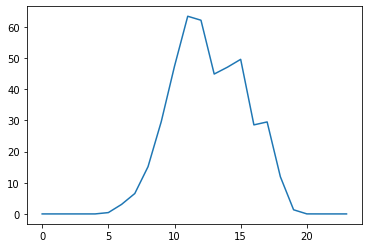

In [7]:
plt.plot(data.groupby('time').sum()['energy'][:24])

In [8]:
X = []
for i in range(0, 10584, 24):
    X.append(data.groupby('time').sum()['energy'][i:i+24].values)
    
X = np.array(X)
X.shape

(441, 24)

In [9]:
target = X[1:]
wX = df_w.iloc[:-1,:].values
data = np.hstack([X[:-1], wX])

In [10]:
target.shape, data.shape

((440, 24), (440, 67))

In [11]:
wX

array([[26., 22., 19., ...,  1.,  1., 14.],
       [27., 22., 19., ...,  1.,  1., 14.],
       [27., 24., 21., ...,  1.,  1., 14.],
       ...,
       [24., 20., 19., ...,  4.,  4., 10.],
       [23., 19., 19., ...,  4.,  4., 11.],
       [22., 19., 18., ...,  4.,  4., 11.]])

In [12]:
# data = data[:,10:18]
# target = target[:,10:18]

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=SEED)

In [17]:
from sklearn.model_selection import train_test_split

tr_X, val_X, tr_y, val_y = train_test_split(data, target, test_size=0.15, random_state=SEED)

In [18]:
rf.fit(tr_X, tr_y)

RandomForestRegressor(random_state=42)

In [19]:
from sklearn.metrics import mean_absolute_error as mae

mae(val_y, rf.predict(val_X))

5.375720870024618

In [20]:
def custom_loss(true, pred):
    ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
    true = true[:,10:18]
    pred = pred[:,10:18]
    
    prior = np.abs(true - pred)
    perfect = np.zeros_like(prior)
    prior = 0.08*113 - prior
    prior = np.where(prior<0, 0, prior)
    score = np.sum(prior * ph)
    
    perfect = 0.08*113 - perfect
    perfect = np.where(perfect<0, 0, perfect)
    perfect = np.sum(perfect * ph)
#     return score
    return -score/perfect+1


def custom_loss_nn(true, pred):
    ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
    true = true[:,10:18]
    pred = pred[:,10:18]
    
    prior = K.abs(true - pred)
    perfect = K.zeros_like(prior)
    prior = 0.08*113 - prior
    prior = tf.where(prior<0, 0, prior)
    score = K.sum(prior * ph)
    
    perfect = 0.08*113 - perfect
    perfect = tf.where(perfect<0, 0, perfect)
    perfect = K.sum(perfect * ph)
#     return score
    return -score/perfect+1

In [21]:
custom_loss(val_y, rf.predict(val_X))

0.7538760010292102

In [47]:
a = np.ones((2, 24))
b = np.ones((2, 24))

custom_loss(a, b)

0.0

In [ ]:
plt.plot(val_y[1])
plt.plot(rf.predict(val_X)[1])

In [1]:
def custom_loss(true, pred):
    ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
#     true = true[:,10:18]
#     pred = pred[:,10:18]
    
    prior = np.abs(true - pred)
    perfect = np.zeros_like(prior)
    prior = 0.08*113 - prior
    prior = np.where(prior<0, 0, prior)
    score = np.sum(prior * ph)

    return score

In [4]:
a = np.array([49, 66.03, 76.71, 76.17, 73.5, 64.31, 44.15, 18.26])
b = np.array([61.68, 80.93, 83.59, 81.32, 71.01, 54.83, 30.56, 7.47])
c = np.array([7.49, 17.78, 37.87, 42.67, 33.62, 27.49, 21.39, 14.71])

q = np.array([20.102, 42.666, 70.44, 68.267, 54.863, 47.898, 37.133, 12.915])

In [5]:
custom_loss(q, a)

864.3478300000004

In [6]:
custom_loss(q, b)

743.8938400000004

In [7]:
custom_loss(q, c)

672.1186499999999

In [21]:
res = 0
ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
# a = np.array([49, 66.03, 76.71, 76.17, 73.5, 64.31, 44.15, 18.26])
const = 0.7
for i in range(8):
    res += max(0.08*113 - np.abs(a[i]*const-q[i]), 0) * ph[i] * 1.5
    print(max(0.08*113 - np.abs(a[i]*const-q[i]), 0) * ph[i] * 1.5)
    
res

0.0
725.5009500000002
0.0
0.0
742.0043549999996
822.134114999999
380.92757999999947
1239.4535850000002


3910.0205849999984

In [239]:
res = 0
ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
for i in range(8):
    res += max(0.08*113 - np.abs(b[i]-q[i]), 0) * ph[i] * 1.5
    print(max(0.08*113 - np.abs(b[i]-q[i]), 0) * ph[i] * 1.5)
    
res

0.0
0.0
0.0
0.0
0.0
281.38638000000077
334.1921549999996
500.26222500000017


1115.8407600000005

In [241]:
res = 0
ph = np.array([88.05, 88.18, 87.67, 84.45, 87.91, 88.99, 90.31, 92.77])
for i in range(8):
    res += max(0.08*113 - np.abs(c[i]-q[i]), 0) * ph[i] * 1.5
    print(max(0.08*113 - np.abs(c[i]-q[i]), 0) * ph[i] * 1.5)
    
res

0.0
0.0
0.0
0.0
0.0
0.0
0.0
1008.1779749999998


1008.1779749999998

In [104]:
64.31-54.861

9.449000000000005

In [105]:
0.08*113

9.040000000000001